CUDA is available! Training will use GPU acceleration.
Loaded 365 historical data points from CSV.

----- Price Prediction Model Evaluation -----
Model coefficients: 0.9968x + 20.5245
Training MAE: 22.00
Test MAE: 28.55
Training RMSE: 32.97
Test RMSE: 42.42
Training R²: 0.9880
Test R²: 0.7512


C:\Users\Kevin\AppData\Local\Temp\ipykernel_11036\2607111854.py:260: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


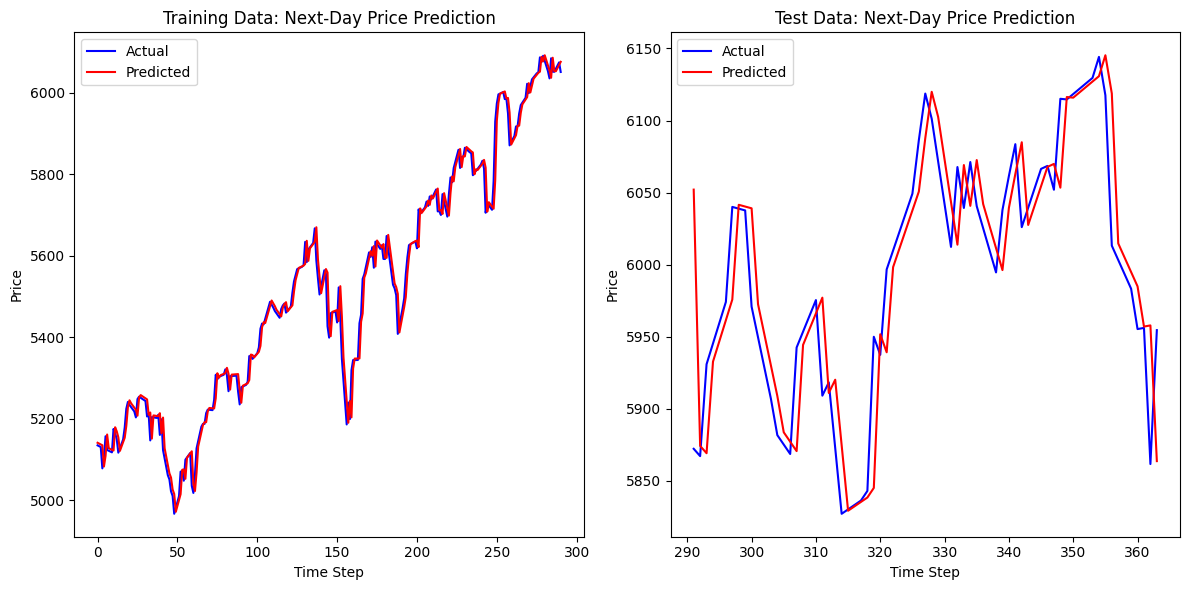

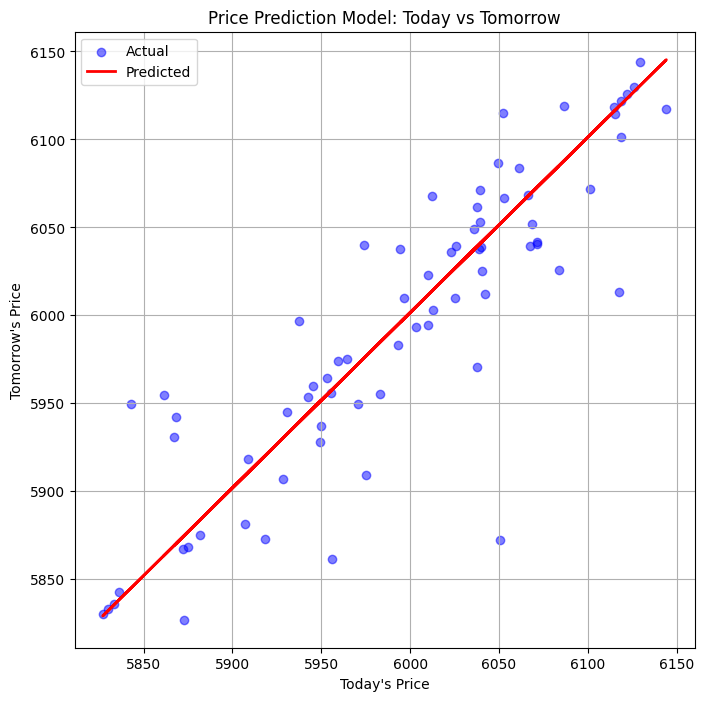

Trained and evaluated supervised learning model for price prediction.

Running DQN simulations...

Running DQN simulation with seed 1000 (1/5)
Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | 12.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 461      |
|    time_elapsed     | 3        |
|    total_timesteps  | 1460     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.116    |
|    n_updates        | 339      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 519      |
|    time_elapsed     | 5        |

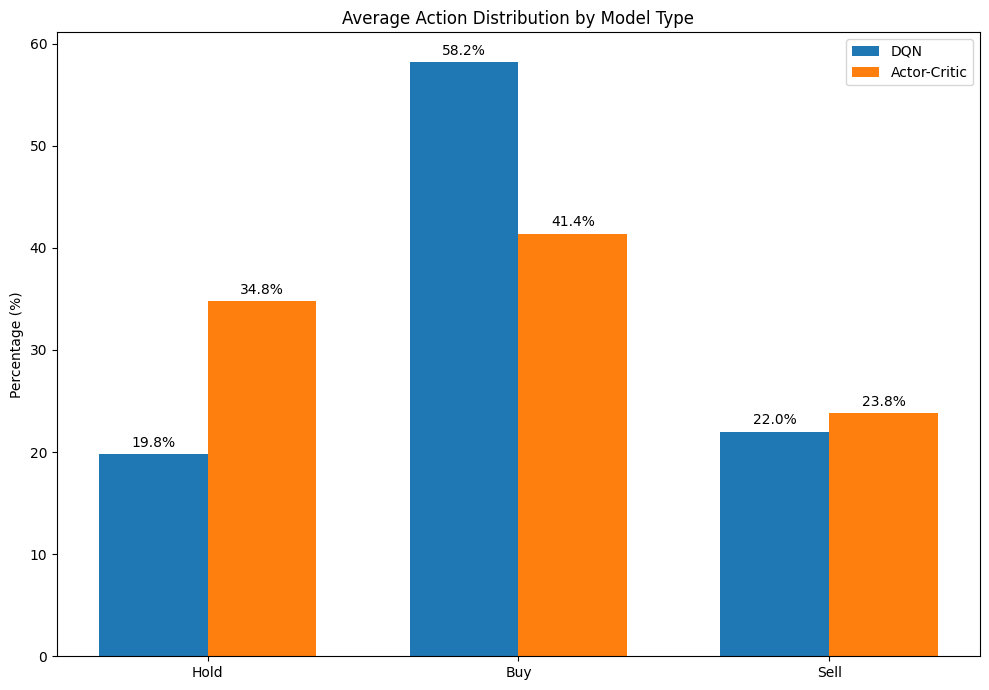

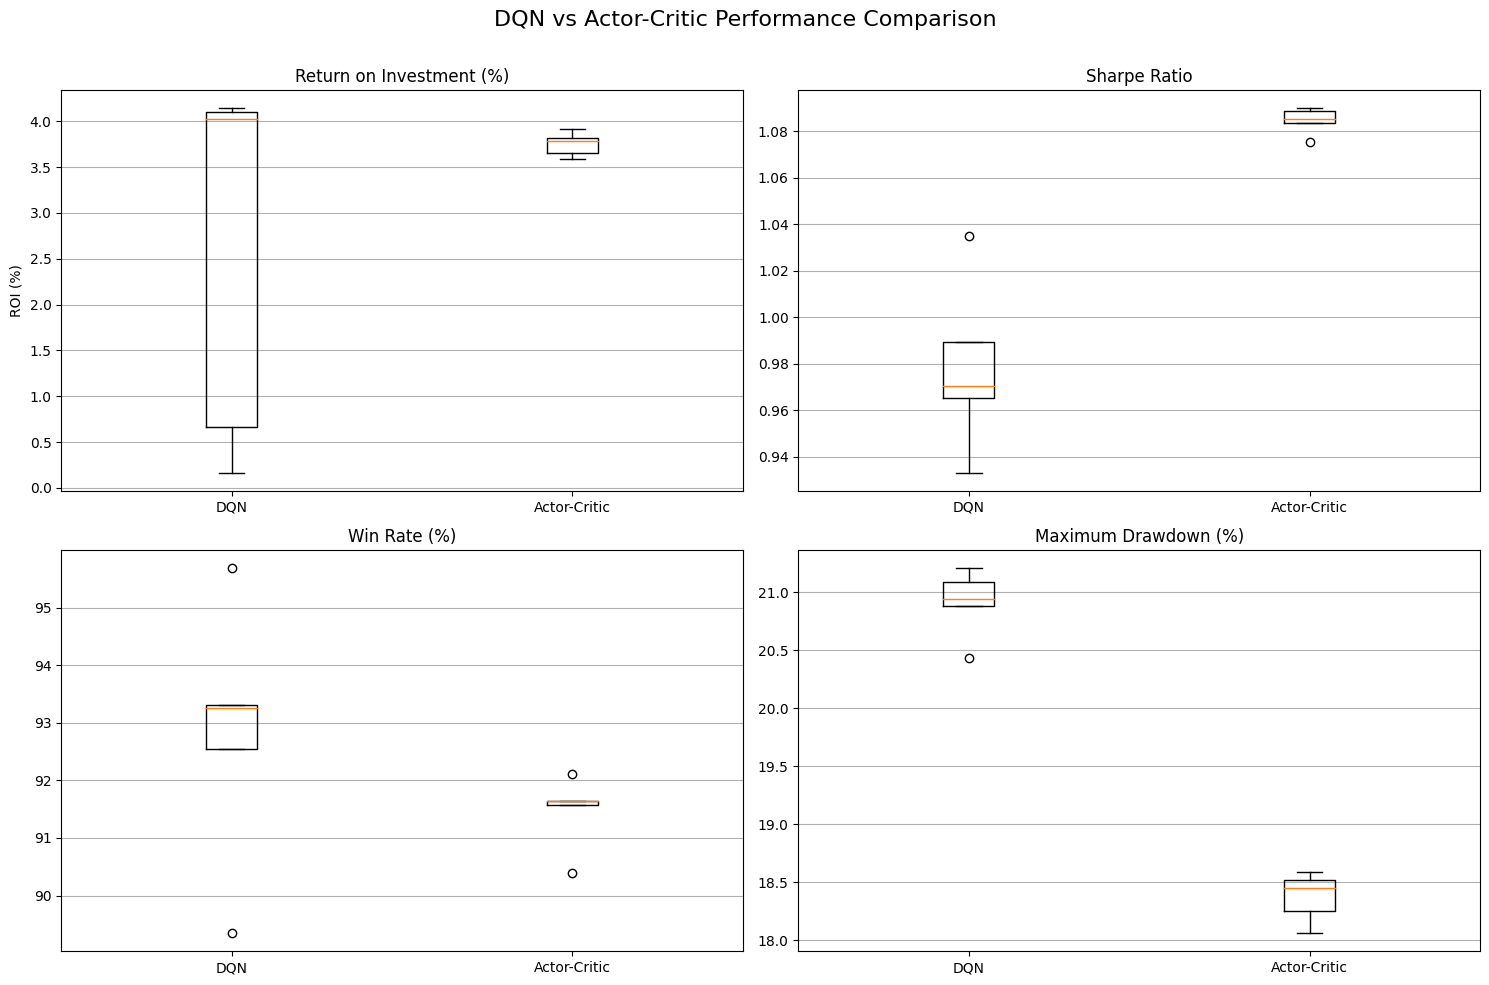

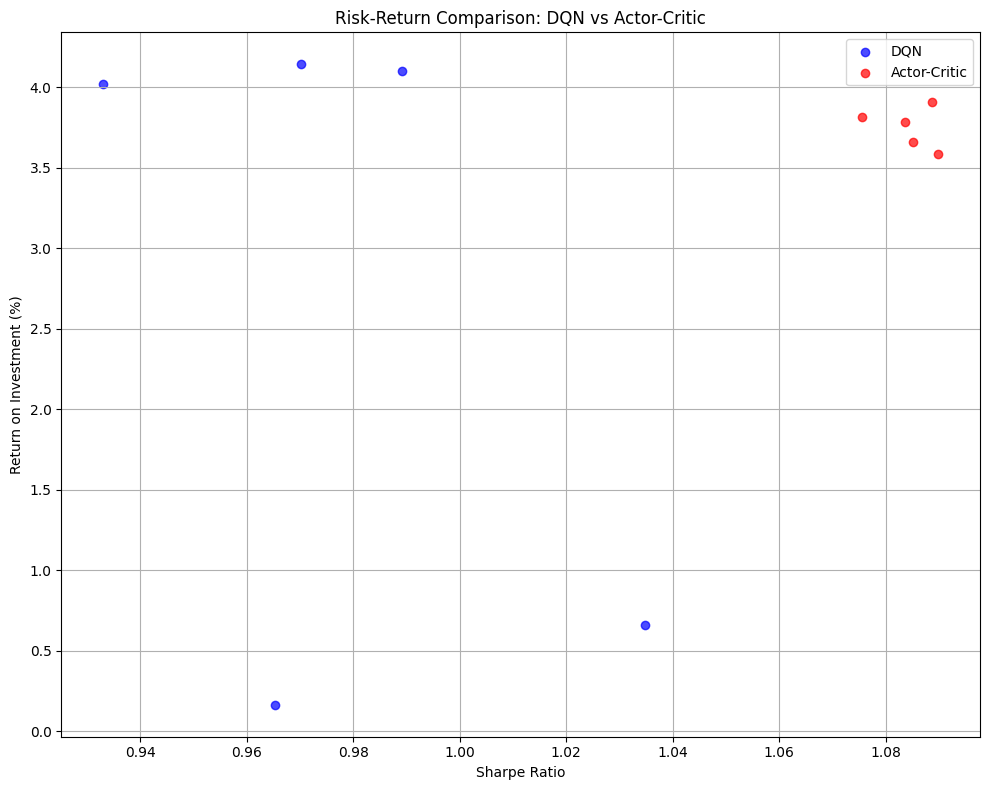


Best overall model: DQN with seed 1003 (ROI: 4.14%)

Detailed report for best DQN model (seed 1003, ROI: 4.14%)

Running DQN with best seed for detailed analysis...
Using cuda device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | 12       |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 629      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1460     |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.0542   |
|    n_updates        | 339      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 365      |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 612      |
|    time_e

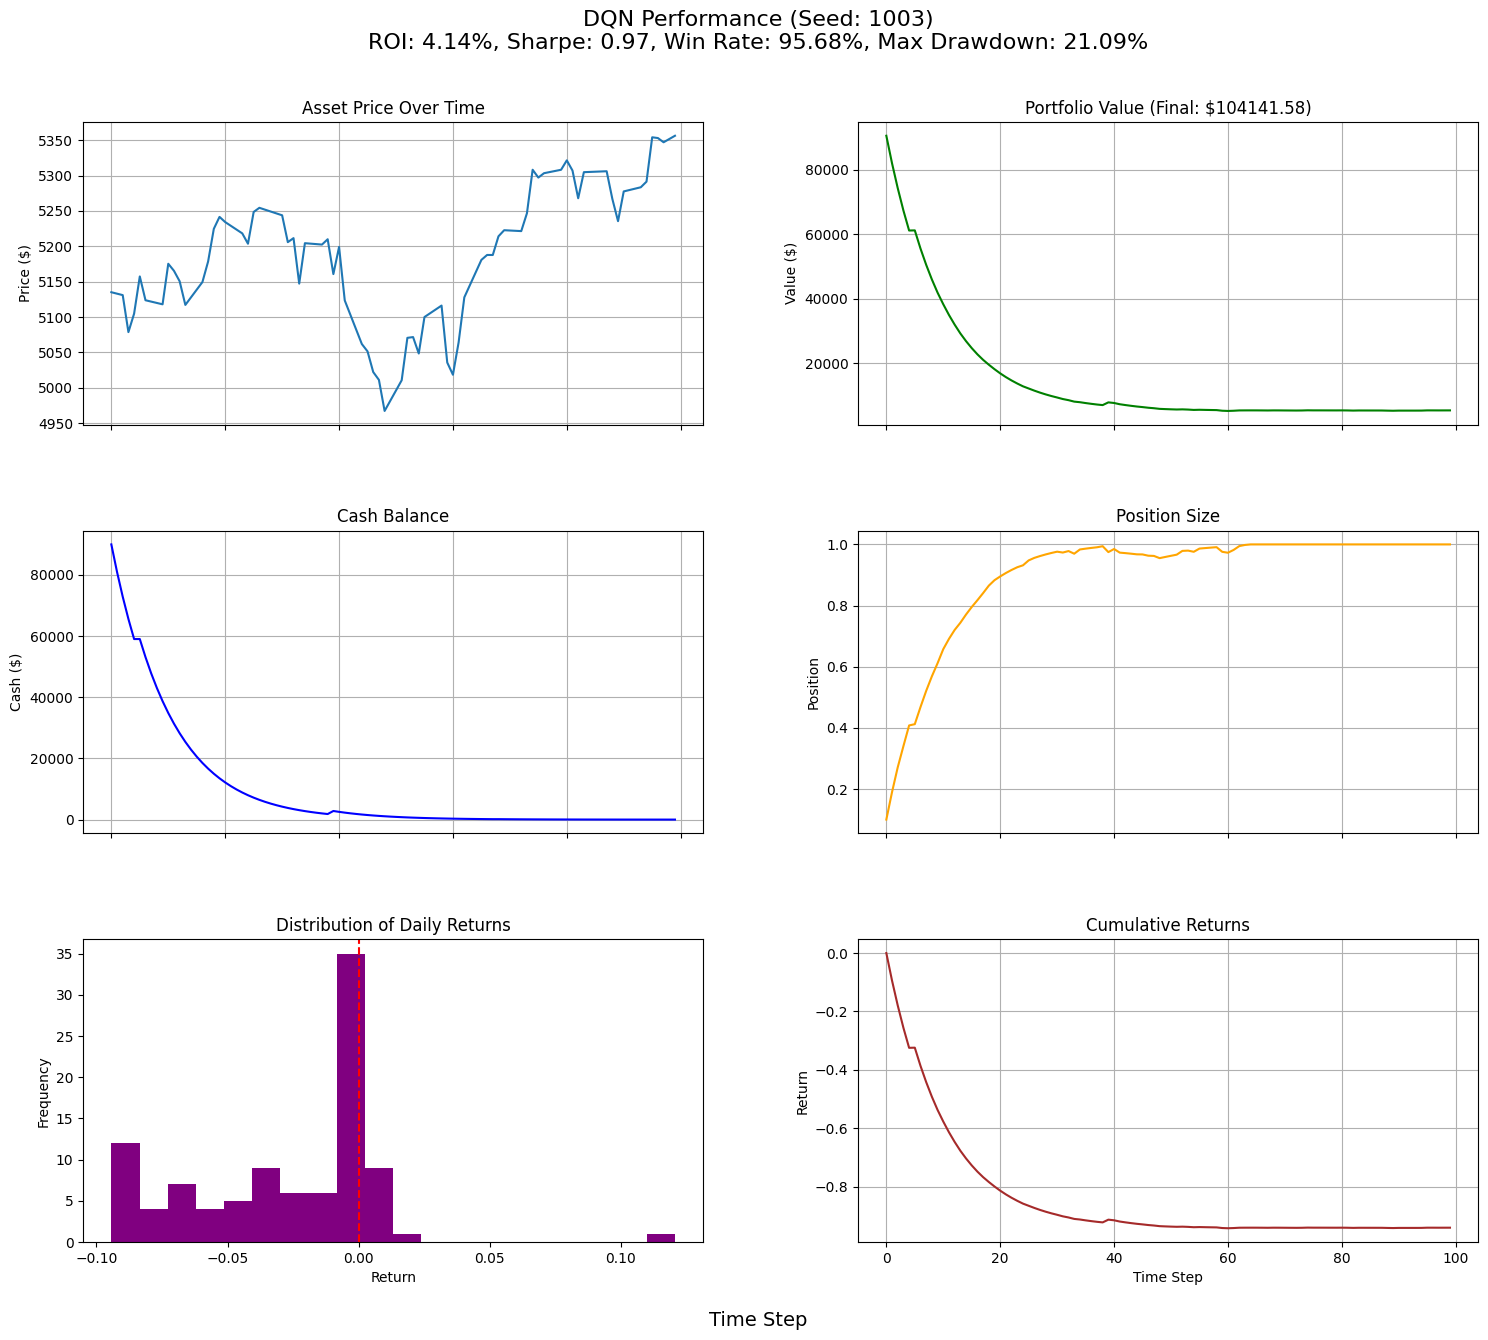


DQN PERFORMANCE SUMMARY (Seed 1003):
  Initial Investment: $100000.00
  Final Portfolio Value: $104141.58
  Return on Investment: 4.14%
  Sharpe Ratio: 0.97
  Win Rate: 95.68%
  Maximum Drawdown: 21.09%
  Action Distribution:
    - Hold: 2.00%
    - Buy: 97.00%
    - Sell: 1.00%

Detailed report for best PPO model (seed 1000, ROI: 3.91%)

Running PPO with best seed for detailed analysis...
Setting PPO to use CPU instead of GPU for better performance with MLP policy
Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 365      |
|    ep_rew_mean     | 13.8     |
| time/              |          |
|    fps             | 1465     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 365         |
|    ep_rew_mean          | 13.8        |
| ti

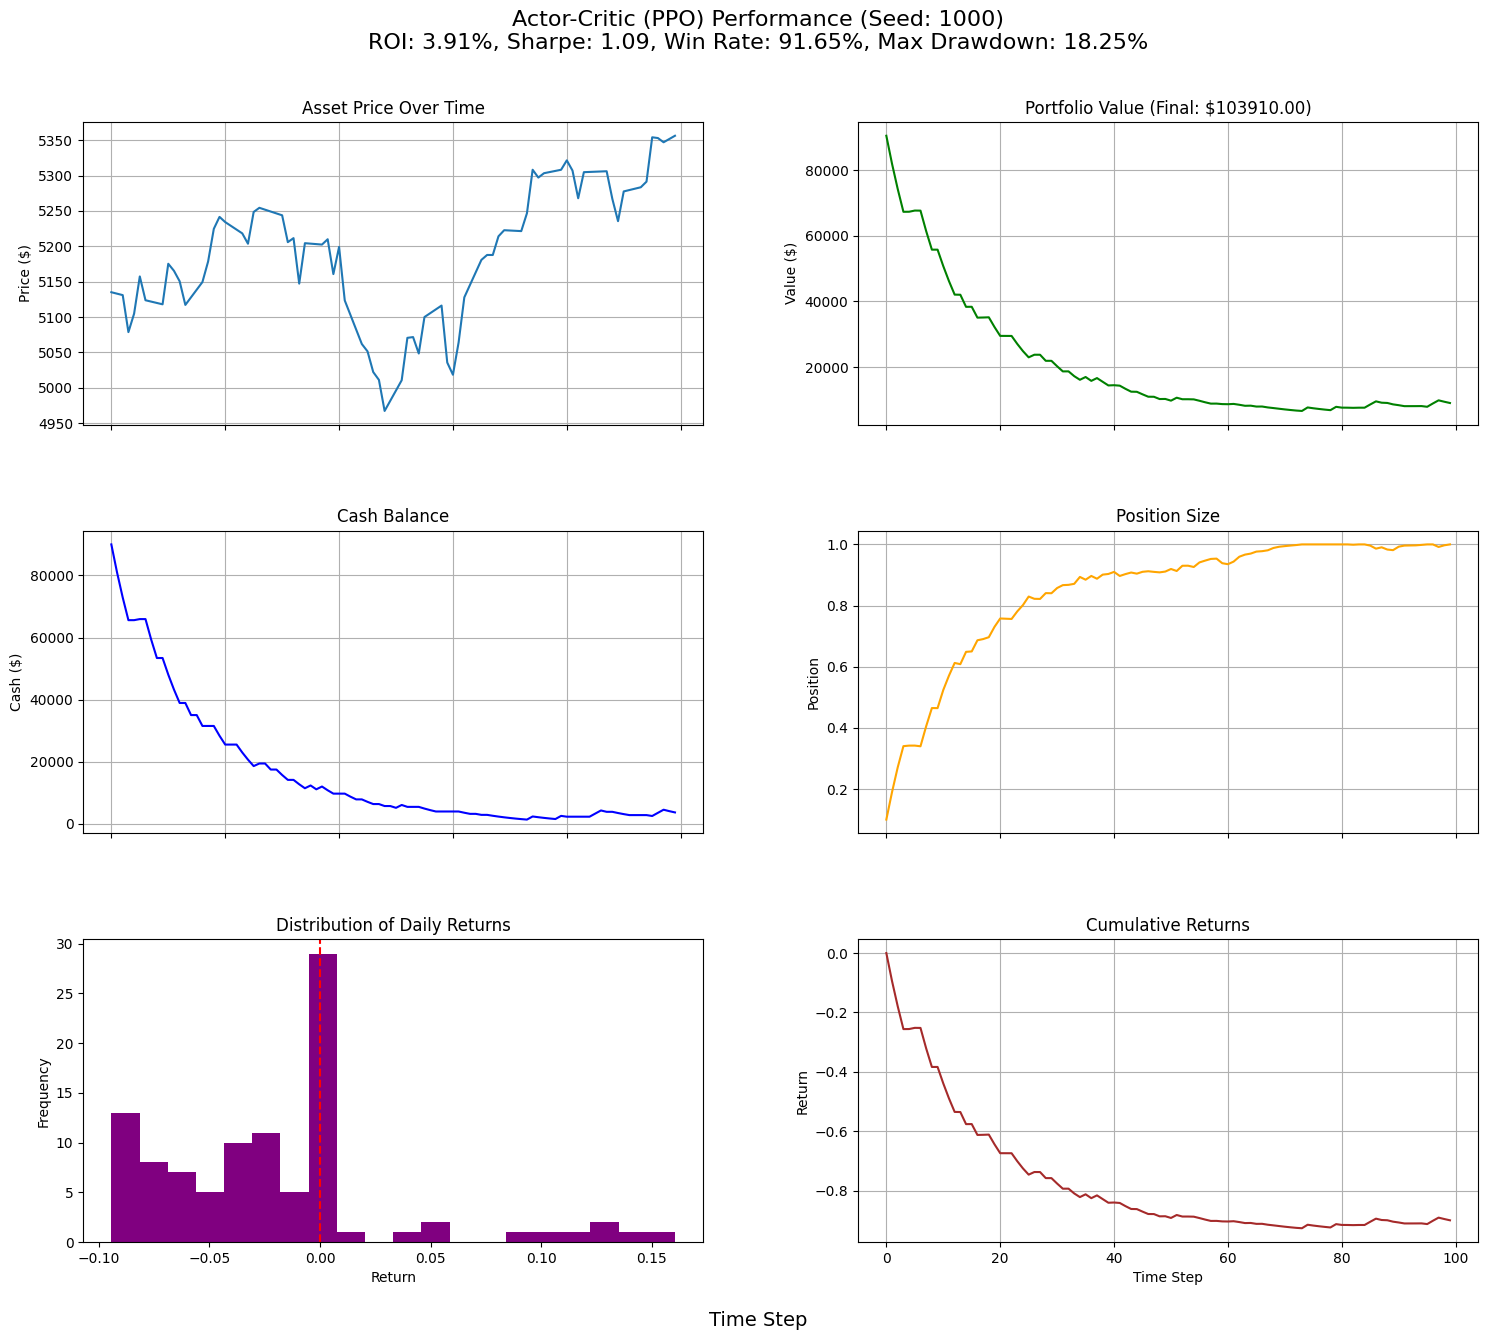


Actor-Critic (PPO) PERFORMANCE SUMMARY (Seed 1000):
  Initial Investment: $100000.00
  Final Portfolio Value: $103910.00
  Return on Investment: 3.91%
  Sharpe Ratio: 1.09
  Win Rate: 91.65%
  Maximum Drawdown: 18.25%
  Action Distribution:
    - Hold: 33.00%
    - Buy: 56.00%
    - Sell: 11.00%



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from stable_baselines3 import DQN , PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from gymnasium import spaces

class TradingEnv(gym.Env):
    """Trading environment for reinforcement learning."""
    metadata = {"render.modes": ["human"]}
    
    def __init__(self, historical_data, sl_model, config=None):
        super(TradingEnv, self).__init__()
        # Default configuration
        self.config = {
            'initial_cash': 100000,
            'transaction_cost': 0.00001,
            'buy_percentage': 0.1,
            'sell_percentage': 0.01,
            'render_mode': None
        }
        # Update with provided config
        if config:
            self.config.update(config)
            
        self.historical_data = historical_data
        self.initial_cash = self.config['initial_cash']
        self.cash = self.initial_cash
        self.position = 0
        self.current_step = 0
        self.render_mode = self.config['render_mode']
        self.sl_model = sl_model
        self.transaction_cost = self.config['transaction_cost']
        self.last_price = self.historical_data[0]['price']
        
        self.portfolio_history = [self.initial_cash]
        self.trades = []
        self.daily_returns = []
        self.purchase_prices = []  # To track purchase prices of positions
        
        # Add action count tracking
        self.action_counts = {0: 0, 1: 0, 2: 0}  # 0: hold, 1: buy, 2: sell
        
        # Define action and observation spaces
        self.action_space = spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = spaces.Box(low=0, high=1, shape=(7,), dtype=np.float32)

    def _get_obs(self):
        """Get the current observation."""
        if self.current_step >= len(self.historical_data):
            current_data = self.historical_data[-1]
        else:
            current_data = self.historical_data[self.current_step]
            
        price = current_data['price']
        norm_price = price / 1000.0
        volatility = current_data['volatility']
        cash_norm = self.cash / self.initial_cash
        
        max_position = self.initial_cash / price if price > 0 else 1
        position_norm = min(self.position / max_position, 1.0)
        
        predicted_price = self.sl_model.predict(np.array([[price]]))[0][0]
        norm_predicted_price = predicted_price / 1000.0
        price_direction = 1 if predicted_price > price else 0
        prediction_diff = abs(predicted_price - price) / price

        return np.array([
            norm_price, 
            volatility, 
            position_norm, 
            cash_norm, 
            norm_predicted_price,
            price_direction,
            prediction_diff
        ], dtype=np.float32)

    def step(self, action):
        """Execute action and return new state, reward, done, and info."""
        # Track action counts
        self.action_counts[action] += 1
        
        current_data = self.historical_data[self.current_step]
        current_price = current_data['price']
        prev_portfolio = self.cash + self.position * current_price

        # Get prediction from the supervised learning model
        predicted_price = self.sl_model.predict(np.array([[current_price]]))[0][0]
        predicted_direction = 1 if predicted_price > current_price else 0
        
        # Track trades
        trade_info = {'type': None, 'profit': 0.0}
        
        # Execute trading action
        if action == 1 and self.cash > 0:  # Buy
            cash_to_use = self.cash * self.config['buy_percentage']
            units = cash_to_use / (current_price * (1 + self.transaction_cost))
            cost = units * current_price * (1 + self.transaction_cost)
            self.cash -= cost
            self.position += units
            
            # Record purchase price for these units
            self.purchase_prices.append((units, current_price))
            
            trade_info['type'] = 'buy'
            trade_info['units'] = units
            trade_info['price'] = current_price
            trade_info['cost'] = cost
            self.trades.append(trade_info)
            
        elif action == 2 and self.position > 0:  # Sell
            units_to_sell = self.position * self.config['sell_percentage']
            sale_value = units_to_sell * current_price
            
            # Calculate accurate cost basis using FIFO method
            units_left_to_sell = units_to_sell
            cost_basis = 0
            
            while units_left_to_sell > 0 and self.purchase_prices:
                units_batch, price_batch = self.purchase_prices[0]
                
                if units_batch <= units_left_to_sell:
                    # Use all of this batch
                    cost_basis += units_batch * price_batch
                    units_left_to_sell -= units_batch
                    self.purchase_prices.pop(0)
                else:
                    # Use part of this batch
                    cost_basis += units_left_to_sell * price_batch
                    self.purchase_prices[0] = (units_batch - units_left_to_sell, price_batch)
                    units_left_to_sell = 0
                    
            trade_info['type'] = 'sell'
            trade_info['units'] = units_to_sell
            trade_info['price'] = current_price
            trade_info['profit'] = sale_value - cost_basis
            revenue = sale_value * (1 - self.transaction_cost)
            self.cash += revenue
            self.position -= units_to_sell
            self.trades.append(trade_info)

        # Move to next step
        self.current_step += 1
        terminated = self.current_step >= len(self.historical_data)
        truncated = False
        
        # Calculate new price and portfolio value
        if not terminated:
            new_data = self.historical_data[self.current_step]
            new_price = new_data['price']
        else:
            new_price = current_price

        new_portfolio = self.cash + self.position * new_price
        self.portfolio_history.append(new_portfolio)
        
        # Calculate daily return
        daily_return = (new_portfolio - prev_portfolio) / prev_portfolio if prev_portfolio > 0 else 0
        self.daily_returns.append(daily_return)
        
        # Calculate rewards
        portfolio_reward = (new_portfolio - prev_portfolio) / prev_portfolio * 100 if prev_portfolio > 0 else 0
        prediction_reward = self._calculate_prediction_reward(action, predicted_direction, predicted_price, current_price)
        reward = portfolio_reward + prediction_reward
        
        self.last_price = new_price
        obs = self._get_obs()
        info = {
            'portfolio_value': new_portfolio,
            'portfolio_reward': portfolio_reward,
            'prediction_reward': prediction_reward
        }
        return obs, reward, terminated, truncated, info
    
    def _calculate_prediction_reward(self, action, predicted_direction, predicted_price, current_price):
        """Calculate reward based on the model's price prediction and action taken."""
        prediction_reward = 0.0
        prediction_confidence = abs(predicted_price - current_price) / current_price
        
        if prediction_confidence > 0.001:
            if predicted_direction == 1:  # Price predicted to go up
                if action == 1:  # Bought
                    prediction_reward = 0.5
                elif action == 2:  # Sold
                    prediction_reward = -0.3
            else:  # Price predicted to go down
                if action == 2:  # Sold
                    prediction_reward = 0.5
                elif action == 1:  # Bought
                    prediction_reward = -0.3
                    
            prediction_reward *= min(prediction_confidence * 10, 1.0)
            
        return prediction_reward

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        if seed is not None:
            np.random.seed(seed)
        self.cash = self.initial_cash
        self.position = 0
        self.current_step = 0
        self.last_price = self.historical_data[0]['price']
        self.purchase_prices = []  # Reset purchase prices tracking
        
        # Reset action counts when environment is reset
        self.action_counts = {0: 0, 1: 0, 2: 0}
        
        return self._get_obs(), {}
    
    def render(self, mode="human"):
        """Render the current state of the environment."""
        current_idx = min(self.current_step, len(self.historical_data) - 1)
        current_data = self.historical_data[current_idx]
        price = current_data['price']
        portfolio_value = self.cash + self.position * price
        if mode == "human":
            print(f"Step: {self.current_step}, Price: {price:.2f}, Cash: {self.cash:.2f}, "
                  f"Position: {self.position:.2f}, Portfolio: {portfolio_value:.2f}")
        return
    
    def get_action_distribution(self):
        """Calculate the percentage distribution of actions taken."""
        total_actions = sum(self.action_counts.values())
        if total_actions == 0:
            return {"hold": 0.0, "buy": 0.0, "sell": 0.0}
        
        return {
            "hold": (self.action_counts[0] / total_actions) * 100,
            "buy": (self.action_counts[1] / total_actions) * 100,
            "sell": (self.action_counts[2] / total_actions) * 100
        }

def load_and_preprocess_data(csv_path):
    """Load and preprocess historical price data from CSV file."""
    df = pd.read_csv(csv_path)

    # Convert and sort by date
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
    df = df[::-1]  # Reverse to get chronological order

    # Clean numeric columns
    numeric_cols = ['Price', 'Open', 'High', 'Low']
    for col in numeric_cols:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)
    
    # Remove unused columns
    if 'Change %' in df.columns:
        df.drop('Change %', axis=1, inplace=True)

    # Fill missing dates with interpolated values
    date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
    df = df.set_index('Date').reindex(date_range).reset_index()
    df.rename(columns={'index': 'Date'}, inplace=True)
    df.interpolate(method='linear', inplace=True)

    # Create historical data structure
    historical_data = []
    for _, row in df.iterrows():
        historical_data.append({
            'price': row['Price'], 
            'volatility': 0.01  # Fixed volatility
        })
    
    print(f"Loaded {len(historical_data)} historical data points from CSV.")
    return df, historical_data

def train_price_prediction_model(df, test_size=0.2, plot=True):
    """Train and evaluate a supervised learning model for price prediction."""
    prices = df['Price'].values.reshape(-1, 1)
    X = prices[:-1]  
    y = prices[1:]   
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    metrics = calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred)
    
    # Print evaluation results
    print_model_evaluation(model, metrics)
    
    # Plot results if requested
    if plot:
        plot_price_prediction_results(
            X_train, y_train, y_train_pred, 
            X_test, y_test, y_test_pred
        )
    
    return model, metrics

def calculate_model_metrics(y_train, y_train_pred, y_test, y_test_pred):
    """Calculate regression metrics for model evaluation."""
    return {
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'test_mae': mean_absolute_error(y_test, y_test_pred),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred)
    }

def print_model_evaluation(model, metrics):
    """Print model evaluation metrics."""
    print("\n----- Price Prediction Model Evaluation -----")
    print(f"Model coefficients: {model.coef_[0][0]:.4f}x + {model.intercept_[0]:.4f}")
    print(f"Training MAE: {metrics['train_mae']:.2f}")
    print(f"Test MAE: {metrics['test_mae']:.2f}")
    print(f"Training RMSE: {metrics['train_rmse']:.2f}")
    print(f"Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Training R²: {metrics['train_r2']:.4f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")

def plot_price_prediction_results(X_train, y_train, y_train_pred, X_test, y_test, y_test_pred):
    """Plot model prediction results."""
    # Time series plot
    plt.figure(figsize=(12, 6))
    
    train_indices = range(len(y_train))
    plt.subplot(1, 2, 1)
    plt.plot(train_indices, y_train, 'b-', label='Actual')
    plt.plot(train_indices, y_train_pred, 'r-', label='Predicted')
    plt.title('Training Data: Next-Day Price Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    
    test_indices = range(len(y_train), len(y_train) + len(y_test))
    plt.subplot(1, 2, 2)
    plt.plot(test_indices, y_test, 'b-', label='Actual')
    plt.plot(test_indices, y_test_pred, 'r-', label='Predicted')
    plt.title('Test Data: Next-Day Price Prediction')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
    plt.plot(X_test, y_test_pred, color='red', linewidth=2, label='Predicted')
    plt.title('Price Prediction Model: Today vs Tomorrow')
    plt.xlabel('Today\'s Price')
    plt.ylabel('Tomorrow\'s Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_trading_simulation(historical_data, sl_model, config=None):
    """Run a trading simulation using the RL agent."""
    if config is None:
        config = {
            'initial_cash': 100000,
            'timesteps': 10000,
            'evaluation_steps': 100,
            'seed': 1073741824,
            'render_mode': "human",
            'device': 'auto'
        }
        
    env_config = {
        'initial_cash': config['initial_cash'],
        'render_mode': config['render_mode']
    }
    
    # Create environment
    env = make_vec_env(
        lambda: TradingEnv(historical_data, sl_model, env_config),
        n_envs=1, 
        seed=config['seed']
    )
    
    # Train RL model
    model = DQN("MlpPolicy", env, verbose=1, 
                learning_rate=0.001, 
                gamma=0.95, 
                seed=config['seed'],
                device=config['device'])
    model.learn(total_timesteps=config['timesteps'])
    
    # Evaluate model
    state_history = []
    policy_log = []
    portfolio_values = []
    obs = env.reset()
    
    for _ in range(config['evaluation_steps']):
        action, _ = model.predict(obs)
        policy_log.append((obs[0], action))
        
        obs, _, done, info = env.step(action)
        state_history.append(obs[0])
        
        if 'portfolio_value' in info[0]:
            portfolio_values.append(info[0]['portfolio_value'])
        
        if done:
            break
    
    # After simulation completes
    env_unwrapped = env.envs[0].unwrapped
    
    # Get action distribution
    action_dist = env_unwrapped.get_action_distribution()
    
    # Calculate metrics
    trades = env_unwrapped.trades
    portfolio_history = env_unwrapped.portfolio_history
    daily_returns = env_unwrapped.daily_returns
    
    # Get the final portfolio value
    final_portfolio = portfolio_history[-1]  
    
    # Win rate calculation
    sell_trades = [t for t in trades if t['type'] == 'sell']
    winning_trades = [t for t in sell_trades if t['profit'] > 0]
    win_rate = len(winning_trades) / len(sell_trades) * 100 if sell_trades else 0
    
    # Sharpe ratio
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    
    # Max drawdown
    max_drawdown = calculate_max_drawdown(portfolio_history)
    
    metrics = {
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'action_distribution': action_dist  # Add action distribution to metrics
    }
    
    # Print results
    print_trading_results(policy_log, final_portfolio, config['initial_cash'], metrics)
    
    return np.array(state_history), final_portfolio, metrics

def run_trading_simulation_ac(historical_data, sl_model, config=None):
    """Run a trading simulation using the Actor-Critic RL agent."""
    if config is None:
        config = {
            'initial_cash': 100000,
            'timesteps': 10000,
            'evaluation_steps': 100,
            'seed': 1073741824,
            'render_mode': "human",
            'device': 'auto'
        }
        
    env_config = {
        'initial_cash': config['initial_cash'],
        'render_mode': config['render_mode']
    }
    
    # Create environment
    env = make_vec_env(
        lambda: TradingEnv(historical_data, sl_model, env_config),
        n_envs=1, 
        seed=config['seed']
    )
    
    # Force CPU for PPO with MLP policy to avoid the warning and potential performance issues
    
    force_gpu = False  
    device = config['device']
    
    if device == 'cuda' and not force_gpu:
        print("Setting PPO to use CPU instead of GPU for better performance with MLP policy")
        device = 'cpu'
    
    # Train Actor-Critic model (PPO)
    model = PPO("MlpPolicy", env, verbose=1, 
                learning_rate=0.0003, 
                gamma=0.95, 
                seed=config['seed'],
                device=device)
                
    model.learn(total_timesteps=config['timesteps'])
    
    # Evaluate model
    state_history = []
    policy_log = []
    portfolio_values = []
    obs = env.reset()
    
    for _ in range(config['evaluation_steps']):
        action, _ = model.predict(obs)
        policy_log.append((obs[0], action))
        
        obs, rewards, dones, info = env.step(action)
        state_history.append(obs[0])
        
        if 'portfolio_value' in info[0]:
            portfolio_values.append(info[0]['portfolio_value'])
        
        if dones:
            break
    
    # After simulation completes
    env_unwrapped = env.envs[0].unwrapped
    
    # Get action distribution
    action_dist = env_unwrapped.get_action_distribution()
    
    # Calculate metrics
    trades = env_unwrapped.trades
    portfolio_history = env_unwrapped.portfolio_history
    daily_returns = env_unwrapped.daily_returns
    
    # Get the final portfolio value
    final_portfolio = portfolio_history[-1]
    
    # Win rate calculation
    sell_trades = [t for t in trades if t['type'] == 'sell']
    winning_trades = [t for t in sell_trades if t['profit'] > 0]
    win_rate = len(winning_trades) / len(sell_trades) * 100 if sell_trades else 0
    
    # Sharpe ratio
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    
    # Max drawdown
    max_drawdown = calculate_max_drawdown(portfolio_history)
    
    metrics = {
        'win_rate': win_rate,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'action_distribution': action_dist  # Add action distribution to metrics
    }
    
    # Print results
    print_trading_results(policy_log, final_portfolio, config['initial_cash'], metrics)
    
    return np.array(state_history), final_portfolio, metrics

def print_trading_results(policy_log, final_portfolio, initial_cash, metrics):
    """Print the results of the trading simulation."""
    print("Optimal Policy (State → Action):")
    for i, (state, action) in enumerate(policy_log):
        norm_price, volatility, position, cash, pred_norm_price, price_direction, prediction_diff = state
        price = norm_price * 1000.0
        predicted_price = pred_norm_price * 1000.0
        print(f"Step {i}: Price=${price:.2f}, Position={position:.2f}, Cash={cash:.2f}")
        print(f"    Prediction=${predicted_price:.2f} (Diff: {prediction_diff*100:.2f}%, Direction: {'Up' if price_direction==1 else 'Down'}) → Action {action}")

    print(f"\nFinal Portfolio Value: ${final_portfolio:.2f}")
    roi = ((final_portfolio / initial_cash) - 1) * 100
    print(f"Return on Investment: {roi:.2f}%")
    print(f"Win Rate: {metrics['win_rate']:.2f}%")
    print(f"Sharpe Ratio: {metrics['sharpe_ratio']:.2f}")
    print(f"Max Drawdown: {metrics['max_drawdown']:.2f}%")

def plot_trading_evolution(state_history, final_portfolio, seed):
    """Plot the evolution of trading parameters over time."""
    steps = np.arange(state_history.shape[0])
    prices = state_history[:, 0] * 1000.0
    positions = state_history[:, 2]
    cash = state_history[:, 3]
    portfolio_value = cash + positions * prices

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(steps, prices, marker='o', linestyle='-')
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.title("Asset Price Over Time")

    plt.subplot(2, 2, 2)
    plt.plot(steps, positions, marker='o', linestyle='-')
    plt.xlabel("Time Step")
    plt.ylabel("Position")
    plt.title("Position Over Time")

    plt.subplot(2, 2, 3)
    plt.plot(steps, cash, marker='o', linestyle='-')
    plt.xlabel("Time Step")
    plt.ylabel("Cash")
    plt.title("Cash Over Time")

    plt.subplot(2, 2, 4)
    plt.plot(steps, portfolio_value, marker='o', linestyle='-')
    plt.xlabel("Time Step")
    plt.ylabel("Portfolio Value")
    plt.title("Portfolio Value Over Time")

    plt.suptitle(f"Trading Results with Seed {seed} - Final Portfolio: ${final_portfolio:.2f}", fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

def run_multiple_seeds(historical_data, sl_model, base_config, num_seeds=50):
    """Run trading simulations with multiple seeds and analyze results."""
    results = []
    
    for i in range(num_seeds):
        seed = 1000 + i  # Different seed for each run
        config = base_config.copy()
        config['seed'] = seed
        
        print(f"\nRunning simulation with seed {seed} ({i+1}/{num_seeds})")
        state_history, final_portfolio, metrics = run_trading_simulation(
            historical_data, sl_model, config
        )
        results.append({
            'seed': seed,
            'final_portfolio': final_portfolio,
            'roi': ((final_portfolio / config['initial_cash']) - 1) * 100,
            'sharpe_ratio': metrics['sharpe_ratio'],
            'win_rate': metrics['win_rate'],
            'max_drawdown': metrics['max_drawdown']
        })
   
    plot_performance_distribution(results)
    
    
    print_consolidated_report(results, base_config['initial_cash'])
    
    
    best_result = plot_best_model_performance(results, historical_data, sl_model, base_config)
    
    return results, best_result

def run_multiple_seeds_with_model(historical_data, sl_model, base_config, model_type="dqn", num_seeds=50):
    """Run trading simulations with multiple seeds and analyze results."""
    results = []
    
    for i in range(num_seeds):
        seed = 1000 + i  # Different seed for each run
        config = base_config.copy()
        config['seed'] = seed
        
        print(f"\nRunning {model_type.upper()} simulation with seed {seed} ({i+1}/{num_seeds})")
        
        if model_type.lower() == "dqn":
            state_history, final_portfolio, metrics = run_trading_simulation(
                historical_data, sl_model, config
            )
        elif model_type.lower() in ["ac", "ppo"]:
            state_history, final_portfolio, metrics = run_trading_simulation_ac(
                historical_data, sl_model, config
            )
        else:
            raise ValueError(f"Unknown model type: {model_type}")
        
        results.append({
            'model': model_type,
            'seed': seed,
            'final_portfolio': final_portfolio,
            'roi': ((final_portfolio / config['initial_cash']) - 1) * 100,
            'sharpe_ratio': metrics['sharpe_ratio'],
            'win_rate': metrics['win_rate'],
            'max_drawdown': metrics['max_drawdown'],
            'action_distribution': metrics['action_distribution']  # Add action distribution
        })
    
    return results

def plot_performance_distribution(results):
    """Create box plots showing performance distribution across seeds."""
    portfolio_values = [r['final_portfolio'] for r in results]
    roi_values = [r['roi'] for r in results]
    sharpe_values = [r['sharpe_ratio'] for r in results]
    win_rate_values = [r['win_rate'] for r in results]
    drawdown_values = [r['max_drawdown'] for r in results]
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.boxplot(portfolio_values)
    plt.title("Final Portfolio Values")
    plt.ylabel("Portfolio Value ($)")
    
    plt.subplot(2, 3, 2)
    plt.boxplot(roi_values)
    plt.title("Return on Investment")
    plt.ylabel("ROI (%)")
    
    plt.subplot(2, 3, 3)
    plt.boxplot(sharpe_values)
    plt.title("Sharpe Ratio")
    plt.ylabel("Ratio")
    
    plt.subplot(2, 3, 4)
    plt.boxplot(win_rate_values)
    plt.title("Win Rate")
    plt.ylabel("Rate (%)")
    
    plt.subplot(2, 3, 5)
    plt.boxplot(drawdown_values)
    plt.title("Maximum Drawdown")
    plt.ylabel("Drawdown (%)")
    
    plt.tight_layout()
    plt.show()

def calculate_sharpe_ratio(returns):
    """Calculate annualized Sharpe ratio from a series of returns."""
    if len(returns) < 2 or np.std(returns) == 0:
        return 0.0
    # Assuming risk-free rate of 0 for simplicity
    # Annualize by multiplying by sqrt(252) - approximately 252 trading days in a year
    return (np.mean(returns) / np.std(returns)) * np.sqrt(252)

def calculate_max_drawdown(portfolio_values):
    """Calculate maximum drawdown from portfolio value history."""
    peak = portfolio_values[0]
    max_drawdown = 0.0
    
    for value in portfolio_values:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_drawdown = max(max_drawdown, drawdown)
        
    return max_drawdown * 100.0  

def print_consolidated_report(results, initial_cash):
    """Print a consolidated report of all simulation results."""
    # Calculate averages
    avg_portfolio = sum(r['final_portfolio'] for r in results) / len(results)
    avg_roi = sum(r['roi'] for r in results) / len(results)
    avg_sharpe = sum(r['sharpe_ratio'] for r in results) / len(results)
    avg_win_rate = sum(r['win_rate'] for r in results) / len(results)
    avg_max_dd = sum(r['max_drawdown'] for r in results) / len(results)
    
    # Find best and worst results
    best_result = max(results, key=lambda x: x['roi'])
    worst_result = min(results, key=lambda x: x['roi'])
    
    print("\n" + "="*50)
    print("       TRADING STRATEGY PERFORMANCE REPORT")
    print("="*50)
    print(f"Initial Investment: ${initial_cash:.2f}")
    print(f"Number of simulations: {len(results)}")
    print("\nAVERAGE METRICS:")
    print(f"  Final Portfolio: ${avg_portfolio:.2f}")
    print(f"  Return on Investment: {avg_roi:.2f}%")
    print(f"  Sharpe Ratio: {avg_sharpe:.2f}")
    print(f"  Win Rate: {avg_win_rate:.2f}%")
    print(f"  Maximum Drawdown: {avg_max_dd:.2f}%")
    
    print("\nBEST PERFORMANCE:")
    print(f"  Seed: {best_result['seed']}")
    print(f"  Final Portfolio: ${best_result['final_portfolio']:.2f}")
    print(f"  ROI: {best_result['roi']:.2f}%")
    print(f"  Sharpe Ratio: {best_result['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {best_result['win_rate']:.2f}%")
    print(f"  Maximum Drawdown: {best_result['max_drawdown']:.2f}%")
    
    print("\nWORST PERFORMANCE:")
    print(f"  Seed: {worst_result['seed']}")
    print(f"  Final Portfolio: ${worst_result['final_portfolio']:.2f}")
    print(f"  ROI: {worst_result['roi']:.2f}%")
    print(f"  Sharpe Ratio: {worst_result['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {worst_result['win_rate']:.2f}%")
    print(f"  Maximum Drawdown: {worst_result['max_drawdown']:.2f}%")
    print("="*50)

def plot_best_model_performance(results, historical_data, sl_model, base_config):
    """Plot detailed performance of the best model."""
    # Find the best model based on ROI
    best_result = max(results, key=lambda x: x['roi'])
    best_seed = best_result['seed']
    
    print(f"\nPlotting detailed performance for best model (seed {best_seed}, ROI: {best_result['roi']:.2f}%)")
    
    # Re-run the best model to get detailed history
    config = base_config.copy()
    config['seed'] = best_seed
    state_history, final_portfolio, metrics = run_trading_simulation(
        historical_data, sl_model, config
    )
    
    # Extract data from state history
    steps = np.arange(state_history.shape[0])
    prices = state_history[:, 0] * 1000.0  # Un-normalize price
    positions = state_history[:, 2]  # Position is already in range 0-1
    cash_values = state_history[:, 3] * base_config['initial_cash']  # Un-normalize cash
    
    # Calculate portfolio values over time
    portfolio_values = cash_values + positions * prices
    
    
    plt.figure(figsize=(18, 14))  
    
    # Price chart with buy/sell markers
    plt.subplot(3, 2, 1)
    plt.plot(steps, prices, marker='', linestyle='-')
    plt.title(f"Asset Price Over Time (Seed {best_seed})")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)  
    
    # Portfolio value
    plt.subplot(3, 2, 2)
    plt.plot(steps, portfolio_values, marker='', linestyle='-', color='green')
    plt.title(f"Portfolio Value (Final: ${final_portfolio:.2f})")
    plt.ylabel("Value ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)  
    
    # Cash balance
    plt.subplot(3, 2, 3)
    plt.plot(steps, cash_values, marker='', linestyle='-', color='blue')
    plt.title("Cash Balance")
    plt.ylabel("Cash ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)  
    
    # Position size
    plt.subplot(3, 2, 4)
    plt.plot(steps, positions, marker='', linestyle='-', color='orange')
    plt.title("Position Size")
    plt.ylabel("Position")
    plt.grid(True)
    plt.tick_params(labelbottom=False)  
    
    # Daily returns histogram
    plt.subplot(3, 2, 5)
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    plt.hist(daily_returns, bins=20, color='purple')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    
    # Cumulative returns
    plt.subplot(3, 2, 6)
    cumulative_returns = np.cumprod(1 + np.append([0], daily_returns)) - 1
    plt.plot(steps, cumulative_returns, color='brown')
    plt.title("Cumulative Returns")
    plt.xlabel("Time Step")
    plt.ylabel("Return")
    plt.grid(True)
    
    
    fig = plt.gcf()
    fig.text(0.5, 0.04, "Time Step", ha='center', fontsize=14)
    
    plt.suptitle(f"Best Model Performance (ROI: {best_result['roi']:.2f}%, Sharpe: {best_result['sharpe_ratio']:.2f}, Win Rate: {best_result['win_rate']:.2f}%)", fontsize=16)
    
    
    plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.35, wspace=0.25)
    
    plt.show()
    
    return best_result

def compare_models(dqn_results, ac_results, initial_cash):
    """Compare performance between DQN and Actor-Critic models."""
    # Calculate model averages
    dqn_avg_portfolio = sum(r['final_portfolio'] for r in dqn_results) / len(dqn_results)
    dqn_avg_roi = sum(r['roi'] for r in dqn_results) / len(dqn_results)
    dqn_avg_sharpe = sum(r['sharpe_ratio'] for r in dqn_results) / len(dqn_results)
    dqn_avg_win_rate = sum(r['win_rate'] for r in dqn_results) / len(dqn_results)
    dqn_avg_max_dd = sum(r['max_drawdown'] for r in dqn_results) / len(dqn_results)
    
    ac_avg_portfolio = sum(r['final_portfolio'] for r in ac_results) / len(ac_results)
    ac_avg_roi = sum(r['roi'] for r in ac_results) / len(ac_results)
    ac_avg_sharpe = sum(r['sharpe_ratio'] for r in ac_results) / len(ac_results)
    ac_avg_win_rate = sum(r['win_rate'] for r in ac_results) / len(ac_results)
    ac_avg_max_dd = sum(r['max_drawdown'] for r in ac_results) / len(ac_results)
    
    # Calculate average action distributions
    dqn_hold = sum(r['action_distribution']['hold'] for r in dqn_results) / len(dqn_results)
    dqn_buy = sum(r['action_distribution']['buy'] for r in dqn_results) / len(dqn_results)
    dqn_sell = sum(r['action_distribution']['sell'] for r in dqn_results) / len(dqn_results)
    
    ac_hold = sum(r['action_distribution']['hold'] for r in ac_results) / len(ac_results)
    ac_buy = sum(r['action_distribution']['buy'] for r in ac_results) / len(ac_results)
    ac_sell = sum(r['action_distribution']['sell'] for r in ac_results) / len(ac_results)
    
    print("\n" + "="*50)
    print("       DQN vs ACTOR-CRITIC PERFORMANCE COMPARISON")
    print("="*50)
    print(f"Initial Investment: ${initial_cash:.2f}")
    print(f"Number of simulations per model: {len(dqn_results)}")
    
    print("\nDQN AVERAGE METRICS:")
    print(f"  Final Portfolio: ${dqn_avg_portfolio:.2f}")
    print(f"  Return on Investment: {dqn_avg_roi:.2f}%")
    print(f"  Sharpe Ratio: {dqn_avg_sharpe:.2f}")
    print(f"  Win Rate: {dqn_avg_win_rate:.2f}%")
    print(f"  Maximum Drawdown: {dqn_avg_max_dd:.2f}%")
    print(f"  Action Distribution:")
    print(f"    - Hold: {dqn_hold:.2f}%")
    print(f"    - Buy: {dqn_buy:.2f}%")
    print(f"    - Sell: {dqn_sell:.2f}%")
    
    print("\nACTOR-CRITIC AVERAGE METRICS:")
    print(f"  Final Portfolio: ${ac_avg_portfolio:.2f}")
    print(f"  Return on Investment: {ac_avg_roi:.2f}%")
    print(f"  Sharpe Ratio: {ac_avg_sharpe:.2f}")
    print(f"  Win Rate: {ac_avg_win_rate:.2f}%")
    print(f"  Maximum Drawdown: {ac_avg_max_dd:.2f}%")
    print(f"  Action Distribution:")
    print(f"    - Hold: {ac_hold:.2f}%")
    print(f"    - Buy: {ac_buy:.2f}%")
    print(f"    - Sell: {ac_sell:.2f}%")
    
    # Find best model for each approach
    best_dqn = max(dqn_results, key=lambda x: x['roi'])
    best_ac = max(ac_results, key=lambda x: x['roi'])
    
    print("\nBEST DQN MODEL:")
    print(f"  Seed: {best_dqn['seed']}")
    print(f"  Final Portfolio: ${best_dqn['final_portfolio']:.2f}")
    print(f"  ROI: {best_dqn['roi']:.2f}%")
    
    print("\nBEST ACTOR-CRITIC MODEL:")
    print(f"  Seed: {best_ac['seed']}")
    print(f"  Final Portfolio: ${best_ac['final_portfolio']:.2f}")
    print(f"  ROI: {best_ac['roi']:.2f}%")
    
    # Add action distribution visualization
    plot_action_distribution_comparison(dqn_results, ac_results)
    
    plot_model_comparison(dqn_results, ac_results)
    
    return dqn_results, ac_results

def plot_action_distribution_comparison(dqn_results, ac_results):
    """Create bar chart comparing action distributions between models."""
    # Calculate average action distributions
    dqn_hold = sum(r['action_distribution']['hold'] for r in dqn_results) / len(dqn_results)
    dqn_buy = sum(r['action_distribution']['buy'] for r in dqn_results) / len(dqn_results)
    dqn_sell = sum(r['action_distribution']['sell'] for r in dqn_results) / len(dqn_results)
    
    ac_hold = sum(r['action_distribution']['hold'] for r in ac_results) / len(ac_results)
    ac_buy = sum(r['action_distribution']['buy'] for r in ac_results) / len(ac_results)
    ac_sell = sum(r['action_distribution']['sell'] for r in ac_results) / len(ac_results)

    # Create bar chart
    labels = ['Hold', 'Buy', 'Sell']
    dqn_values = [dqn_hold, dqn_buy, dqn_sell]
    ac_values = [ac_hold, ac_buy, ac_sell]

    x = np.arange(len(labels))
    width = 0.35

    # Fix: Create figure and axes correctly
    fig = plt.figure(figsize=(10, 7))
    rects1 = plt.bar(x - width/2, dqn_values, width, label='DQN')
    rects2 = plt.bar(x + width/2, ac_values, width, label='Actor-Critic')

    plt.ylabel('Percentage (%)')
    plt.title('Average Action Distribution by Model Type')
    plt.xticks(x, labels)
    plt.legend()

    # Add value labels on bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            plt.annotate(f'{height:.1f}%',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

def plot_model_comparison(dqn_results, ac_results):
    """Create visualizations comparing DQN and Actor-Critic performance."""
    # Extract metrics
    dqn_roi = [r['roi'] for r in dqn_results]
    dqn_sharpe = [r['sharpe_ratio'] for r in dqn_results]
    dqn_win_rate = [r['win_rate'] for r in dqn_results]
    dqn_max_dd = [r['max_drawdown'] for r in dqn_results]
    
    ac_roi = [r['roi'] for r in ac_results]
    ac_sharpe = [r['sharpe_ratio'] for r in ac_results]
    ac_win_rate = [r['win_rate'] for r in ac_results]
    ac_max_dd = [r['max_drawdown'] for r in ac_results]
    
    # Create box plots for comparison
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.boxplot([dqn_roi, ac_roi], labels=['DQN', 'Actor-Critic'])
    plt.title("Return on Investment (%)")
    plt.ylabel("ROI (%)")
    plt.grid(axis='y')
    
    plt.subplot(2, 2, 2)
    plt.boxplot([dqn_sharpe, ac_sharpe], labels=['DQN', 'Actor-Critic'])
    plt.title("Sharpe Ratio")
    plt.grid(axis='y')
    
    plt.subplot(2, 2, 3)
    plt.boxplot([dqn_win_rate, ac_win_rate], labels=['DQN', 'Actor-Critic'])
    plt.title("Win Rate (%)")
    plt.grid(axis='y')
    
    plt.subplot(2, 2, 4)
    plt.boxplot([dqn_max_dd, ac_max_dd], labels=['DQN', 'Actor-Critic'])
    plt.title("Maximum Drawdown (%)")
    plt.grid(axis='y')
    
    plt.suptitle("DQN vs Actor-Critic Performance Comparison", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    # Create a scatter plot of ROI vs Sharpe ratio
    plt.figure(figsize=(10, 8))
    plt.scatter([r['sharpe_ratio'] for r in dqn_results], 
                [r['roi'] for r in dqn_results], 
                alpha=0.7, label='DQN', color='blue')
    plt.scatter([r['sharpe_ratio'] for r in ac_results], 
                [r['roi'] for r in ac_results], 
                alpha=0.7, label='Actor-Critic', color='red')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Return on Investment (%)')
    plt.title('Risk-Return Comparison: DQN vs Actor-Critic')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_detailed_model_performance(state_history, final_portfolio, model_result, config, model_name):
    """Plot detailed performance of a specific model."""
    # Extract data from state history
    steps = np.arange(state_history.shape[0])
    prices = state_history[:, 0] * 1000.0  # Un-normalize price
    positions = state_history[:, 2]  
    cash_values = state_history[:, 3] * config['initial_cash']  # Un-normalize cash
    
    # Calculate portfolio values over time
    portfolio_values = cash_values + positions * prices
    
    # Create a comprehensive visualization with better spacing
    plt.figure(figsize=(18, 14))
    
    # Price chart
    plt.subplot(3, 2, 1)
    plt.plot(steps, prices, marker='', linestyle='-')
    plt.title(f"Asset Price Over Time")
    plt.ylabel("Price ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)
    
    # Portfolio value
    plt.subplot(3, 2, 2)
    plt.plot(steps, portfolio_values, marker='', linestyle='-', color='green')
    plt.title(f"Portfolio Value (Final: ${final_portfolio:.2f})")
    plt.ylabel("Value ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)
    
    # Cash balance
    plt.subplot(3, 2, 3)
    plt.plot(steps, cash_values, marker='', linestyle='-', color='blue')
    plt.title("Cash Balance")
    plt.ylabel("Cash ($)")
    plt.grid(True)
    plt.tick_params(labelbottom=False)
    
    # Position size
    plt.subplot(3, 2, 4)
    plt.plot(steps, positions, marker='', linestyle='-', color='orange')
    plt.title("Position Size")
    plt.ylabel("Position")
    plt.grid(True)
    plt.tick_params(labelbottom=False)
    
    # Daily returns histogram
    plt.subplot(3, 2, 5)
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    plt.hist(daily_returns, bins=20, color='purple')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Return")
    plt.ylabel("Frequency")
    
    # Cumulative returns
    plt.subplot(3, 2, 6)
    cumulative_returns = np.cumprod(1 + np.append([0], daily_returns)) - 1
    plt.plot(steps, cumulative_returns, color='brown')
    plt.title("Cumulative Returns")
    plt.xlabel("Time Step")
    plt.ylabel("Return")
    plt.grid(True)
    
    # Add a big x-label for all time-series plots
    fig = plt.gcf()
    fig.text(0.5, 0.04, "Time Step", ha='center', fontsize=14)
    
    # Show detailed performance metrics in the title
    plt.suptitle(f"{model_name} Performance (Seed: {model_result['seed']})\n" + 
                 f"ROI: {model_result['roi']:.2f}%, Sharpe: {model_result['sharpe_ratio']:.2f}, " + 
                 f"Win Rate: {model_result['win_rate']:.2f}%, Max Drawdown: {model_result['max_drawdown']:.2f}%", fontsize=16)
    
    # Adjust spacing between subplots
    plt.subplots_adjust(top=0.9, bottom=0.1, hspace=0.35, wspace=0.25)
    plt.show()
    
    # Additional trade statistics
    print(f"\n{model_name} PERFORMANCE SUMMARY (Seed {model_result['seed']}):")
    print(f"  Initial Investment: ${config['initial_cash']:.2f}")
    print(f"  Final Portfolio Value: ${final_portfolio:.2f}")
    print(f"  Return on Investment: {model_result['roi']:.2f}%")
    print(f"  Sharpe Ratio: {model_result['sharpe_ratio']:.2f}")
    print(f"  Win Rate: {model_result['win_rate']:.2f}%")
    print(f"  Maximum Drawdown: {model_result['max_drawdown']:.2f}%")
    print(f"  Action Distribution:")
    print(f"    - Hold: {model_result['action_distribution']['hold']:.2f}%")
    print(f"    - Buy: {model_result['action_distribution']['buy']:.2f}%")
    print(f"    - Sell: {model_result['action_distribution']['sell']:.2f}%")

def main():
    """Main function to run the trading simulation with multiple models and seeds."""
    # Base configuration
    base_config = {
        'csv_path': "S&P 500 Historical Data.csv",
        'initial_cash': 100000,
        'timesteps': 10000,
        'evaluation_steps': 100,
        'render_mode': None,  
        'device': 'auto'  
    }
    
    # Check for CUDA availability
    import torch
    if torch.cuda.is_available():
        print("CUDA is available! Training will use GPU acceleration.")
        base_config['device'] = 'cuda'
    else:
        print("CUDA not available. Training will use CPU.")
        base_config['device'] = 'cpu'
    
    # Load and preprocess data
    df, historical_data = load_and_preprocess_data(base_config['csv_path'])
    
    # Train and evaluate price prediction model
    sl_model, _ = train_price_prediction_model(df)
    print("Trained and evaluated supervised learning model for price prediction.")
    
    # Set number of seeds for each model
    num_seeds = 5  #can adjust this value
    
    # Run simulations with DQN
    print("\n" + "="*50)
    print("Running DQN simulations...")
    dqn_results = run_multiple_seeds_with_model(
        historical_data, sl_model, base_config, 
        model_type="dqn", num_seeds=num_seeds
    )
    
    # Run simulations with Actor-Critic
    print("\n" + "="*50)
    print("Running Actor-Critic simulations...")
    ac_results = run_multiple_seeds_with_model(
        historical_data, sl_model, base_config, 
        model_type="ac", num_seeds=num_seeds
    )
    
    # Compare model performances
    compare_models(dqn_results, ac_results, base_config['initial_cash'])
    
    # Find best overall model
    all_results = dqn_results + ac_results
    best_result = max(all_results, key=lambda x: x['roi'])
    
    print(f"\nBest overall model: {best_result['model'].upper()} with seed {best_result['seed']} (ROI: {best_result['roi']:.2f}%)")
    
    # Find best model for each algorithm type
    best_dqn = max(dqn_results, key=lambda x: x['roi'])
    best_ac = max(ac_results, key=lambda x: x['roi'])
    
    # Plot best DQN model performance
    print("\n" + "="*50)
    print(f"Detailed report for best DQN model (seed {best_dqn['seed']}, ROI: {best_dqn['roi']:.2f}%)")
    dqn_config = base_config.copy()
    dqn_config['seed'] = best_dqn['seed']
    print("\nRunning DQN with best seed for detailed analysis...")
    dqn_state_history, dqn_final_portfolio, dqn_metrics = run_trading_simulation(
        historical_data, sl_model, dqn_config
    )
    plot_detailed_model_performance(
        dqn_state_history, dqn_final_portfolio, best_dqn, dqn_config, "DQN"
    )
    
    # Plot best Actor-Critic model performance
    print("\n" + "="*50)
    print(f"Detailed report for best PPO model (seed {best_ac['seed']}, ROI: {best_ac['roi']:.2f}%)")
    ac_config = base_config.copy()
    ac_config['seed'] = best_ac['seed']
    print("\nRunning PPO with best seed for detailed analysis...")
    ac_state_history, ac_final_portfolio, ac_metrics = run_trading_simulation_ac(
        historical_data, sl_model, ac_config
    )
    plot_detailed_model_performance(
        ac_state_history, ac_final_portfolio, best_ac, ac_config, "Actor-Critic (PPO)"
    )
    
    # Plot best overall model performance
    print("\n" + "="*50)
    if best_result['seed'] != best_dqn['seed'] and best_result['seed'] != best_ac['seed']:
        print("\n" + "="*50)
        print(f"Detailed report for best overall model: {best_result['model'].upper()} (seed {best_result['seed']}, ROI: {best_result['roi']:.2f}%)")
        config = base_config.copy()
        config['seed'] = best_result['seed']
        
        if best_result['model'].lower() == 'dqn':
            plot_trading_evolution(*run_trading_simulation(historical_data, sl_model, config), best_result['seed'])
        else:
            plot_trading_evolution(*run_trading_simulation_ac(historical_data, sl_model, config), best_result['seed'])

if __name__ == "__main__":
    main()
